In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Code for Data & Category Analysis, and Product Distribution Analysis

--- Loading Data: /content/drive/MyDrive/Colab Notebooks/reduced_icecat_data_train_transformed.json ---
Applying Strict Level-3 Truncation and Filtering...

[DISTRIBUTION PRE-FILTER]
Max products in a category: 6401
Min products in a category: 1
Purged categories with < 50 products. Remaining categories: 56
Calculated Optimum N (Mean of valid groups): 530


/tmp/ipython-input-395249521.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Level_3').apply(lambda x: x.sample(n=min(len(x), optimum_N), random_state=42)).reset_index(drop=True)


Performing Distribution Analysis on Curated Data



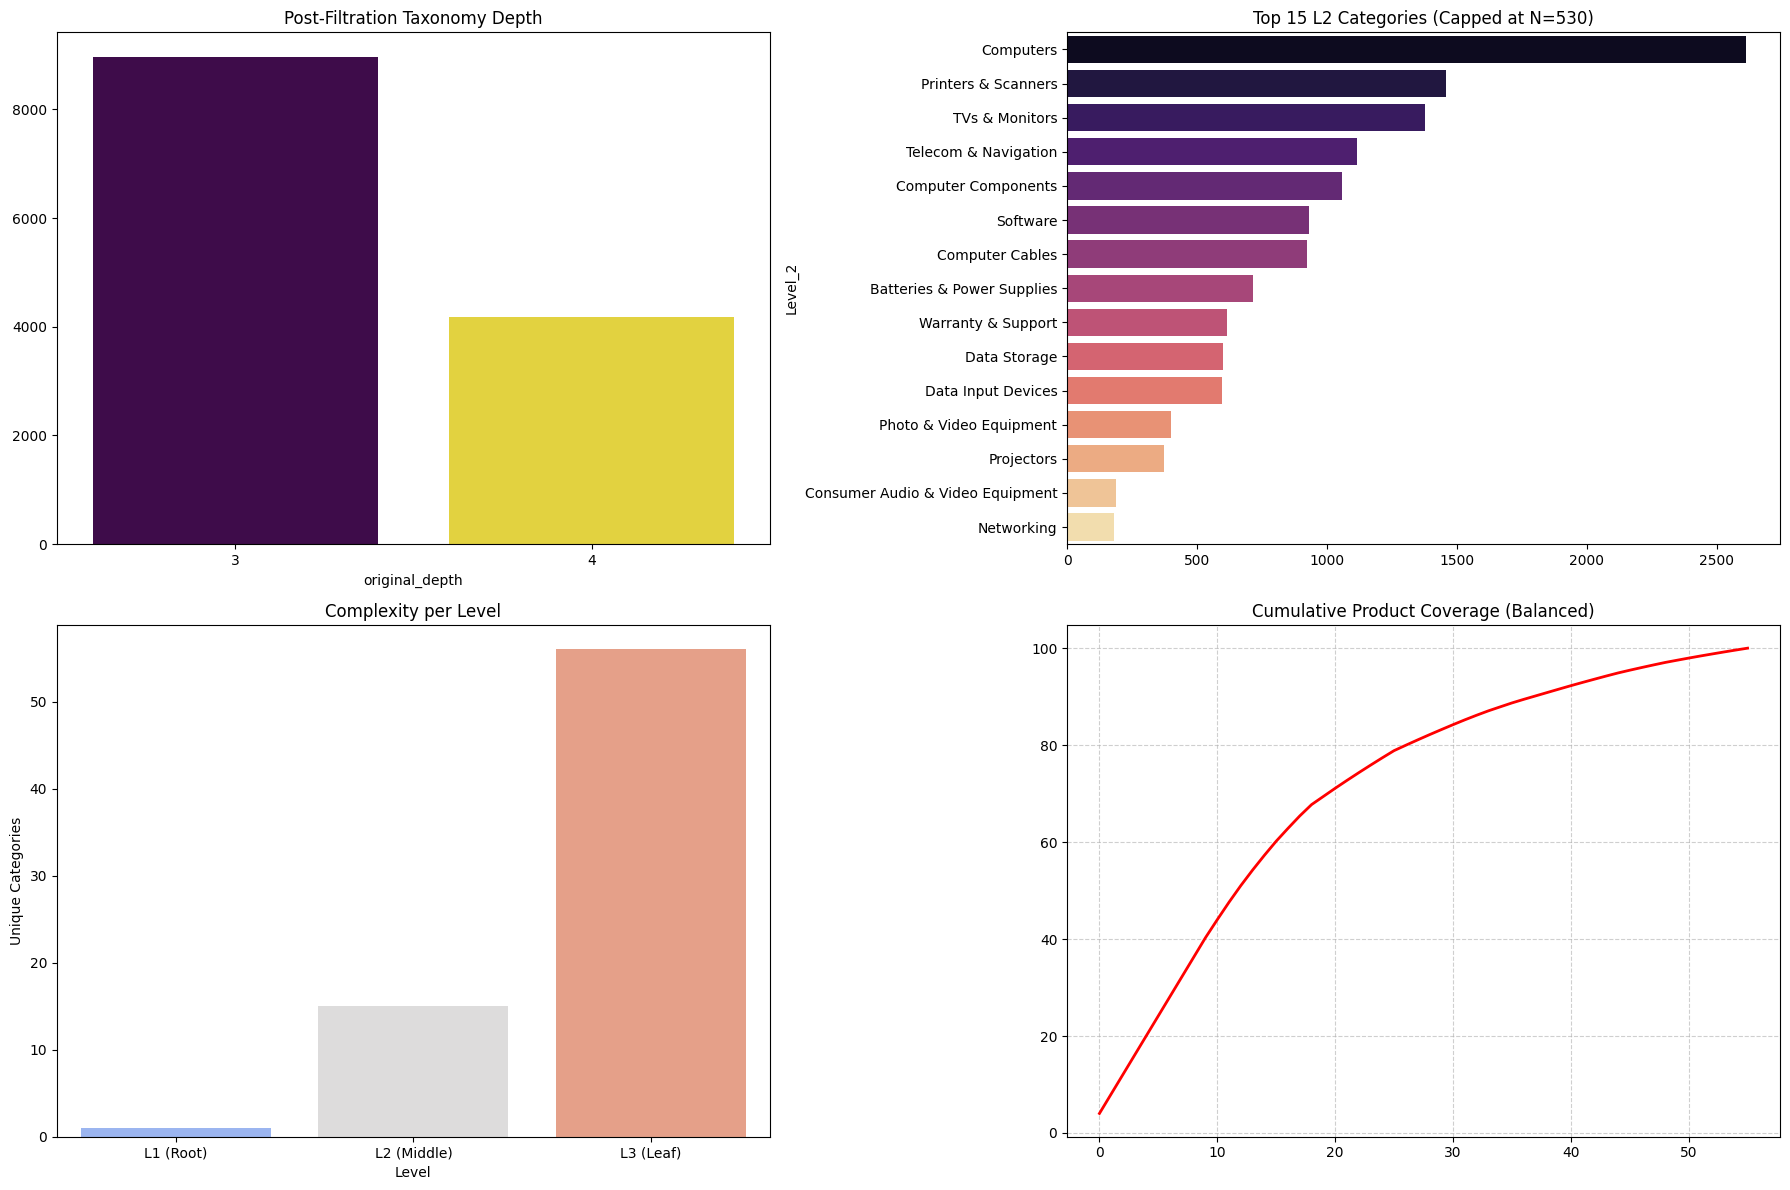

Total Products Analyzed: 13153
Unique Level 3 (Standardized Leaves): 56


In [5]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def perform_curated_category_analysis(file_path, min_threshold=50):
    # 1. Load Dataset
    print(f"--- Loading Data: {file_path} ---")
    with open(file_path, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)

    # POINT 1: No Padding & Hard Truncation
    # We remove products with < 3 levels and truncate deeper ones to exactly 3
    def process_hierarchy(path_str):
        if pd.isna(path_str): return None
        levels = [l.strip() for l in str(path_str).split('>')]
        if len(levels) < 3:
            return None # This triggers the removal of the record
        return levels[:3] # This is the hard truncation to Level 3

    print("Applying Strict Level-3 Truncation and Filtering...")
    df['temp_levels'] = df['pathlist_names'].apply(process_hierarchy)
    df = df.dropna(subset=['temp_levels']).copy()

    df['Level_1'] = df['temp_levels'].apply(lambda x: x[0])
    df['Level_2'] = df['temp_levels'].apply(lambda x: x[1])
    df['Level_3'] = df['temp_levels'].apply(lambda x: x[2])

    # # POINT 3: Enforce Minimum Threshold (Purge sparse categories)
    # l3_counts_pre_balance = df['Level_3'].value_counts()
    # valid_categories = l3_counts_pre_balance[l3_counts_pre_balance >= min_threshold].index
    # df = df[df['Level_3'].isin(valid_categories)].copy()

    # # POINT 2: Algorithmic Balancing (Deciding N)
    # # We use the Median category size to ensure each category has an 'Optimum N'
    # optimum_N = int(df['Level_3'].value_counts().median())
    # print(f"Algorithmic Optimum N (Median): {optimum_N}")

    # POINT 3: Find Min and Max BEFORE balancing
    initial_counts = df['Level_3'].value_counts()
    print(f"\n[DISTRIBUTION PRE-FILTER]")
    print(f"Max products in a category: {initial_counts.max()}")
    print(f"Min products in a category: {initial_counts.min()}")

    # Enforce the Min Threshold as you requested (e.g., increasing to 60)
    valid_categories = initial_counts[initial_counts >= min_threshold].index
    df = df[df['Level_3'].isin(valid_categories)].copy()
    print(f"Purged categories with < {min_threshold} products. Remaining categories: {len(valid_categories)}")

    # POINT 2: Algorithmic N
    # After removing the tiny groups, we find the average size of the remaining ones
    post_filter_counts = df['Level_3'].value_counts()
    optimum_N = int(post_filter_counts.mean()) # Using Mean for a representative N
    print(f"Calculated Optimum N (Mean of valid groups): {optimum_N}")

    # Cap each category to N products to solve data imbalance
    df = df.groupby('Level_3').apply(lambda x: x.sample(n=min(len(x), optimum_N), random_state=42)).reset_index(drop=True)

    # --- RE-INSERTED VISUALIZATION BLOCK (Kept Intact) ---
    print("Performing Distribution Analysis on Curated Data\n")
    l1_counts = df['Level_1'].value_counts()
    l2_counts = df['Level_2'].value_counts()
    l3_counts = df['Level_3'].value_counts()

    plt.style.use('seaborn-v0_8-muted')
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # Plot 1: Category Depth (Now should only show 3+)
    df['original_depth'] = df['pathlist_names'].str.split('>').str.len()
    depth_dist = df['original_depth'].value_counts().sort_index()
    sns.barplot(x=depth_dist.index, y=depth_dist.values, ax=axes[0, 0], palette='viridis', hue=depth_dist.index, legend=False)
    axes[0, 0].set_title('Post-Filtration Taxonomy Depth')

    # Plot 2: Top Level 2 Categories
    top_l2 = l2_counts.head(15)
    sns.barplot(x=top_l2.values, y=top_l2.index, ax=axes[0, 1], palette='magma', hue=top_l2.index, legend=False)
    axes[0, 1].set_title(f'Top 15 L2 Categories (Capped at N={optimum_N})')

    # Plot 3: Complexity Expansion
    level_summary = pd.DataFrame({
        'Level': ['L1 (Root)', 'L2 (Middle)', 'L3 (Leaf)'],
        'Unique Categories': [df['Level_1'].nunique(), df['Level_2'].nunique(), df['Level_3'].nunique()]
    })
    sns.barplot(data=level_summary, x='Level', y='Unique Categories', ax=axes[1, 0], palette='coolwarm', hue='Level', legend=False)
    axes[1, 0].set_title('Complexity per Level')

    # Plot 4: Product Concentration (CPC Graph)
    # Because of balancing, this line should be much straighter (less Pareto skew)
    axes[1, 1].plot(range(len(l3_counts)), l3_counts.cumsum() / l3_counts.sum() * 100, color='red', linewidth=2)
    axes[1, 1].set_title('Cumulative Product Coverage (Balanced)')
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    print(f"Total Products Analyzed: {len(df)}")
    print(f"Unique Level 3 (Standardized Leaves): {df['Level_3'].nunique()}")
    return df

# Execute Analysis
dataset_path = '/content/drive/MyDrive/Colab Notebooks/reduced_icecat_data_train_transformed.json'
analyzed_df = perform_curated_category_analysis(dataset_path)

In [ ]:
'!pip install -U sentence-transformers scikit-learn matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 78.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 5.1.2
    Uninstalling sentence-transformers-5.1.2:
      Successfully uninstalled sentence-transformers-5.1.2


Machine Learning & Categorization Plan

Robust Feature Fusion (Handling Lists & Strings)

Generating 384D Embeddings on CUDA



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/103 [00:00<?, ?it/s]

Running Elbow Method for DBSCAN Epsilon Optimization...



/tmp/ipython-input-1836110168.py:61: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  dist_to_line = np.abs(np.cross(p2-p1, p1-all_points)) / np.linalg.norm(p2-p1)


Mathematically Optimized Epsilon: 20.1223


5. Final Evaluation Metrics (Alignment with Level_3)

V-Measure Score: 0.0142
Adjusted Rand Index (ARI): 0.0005


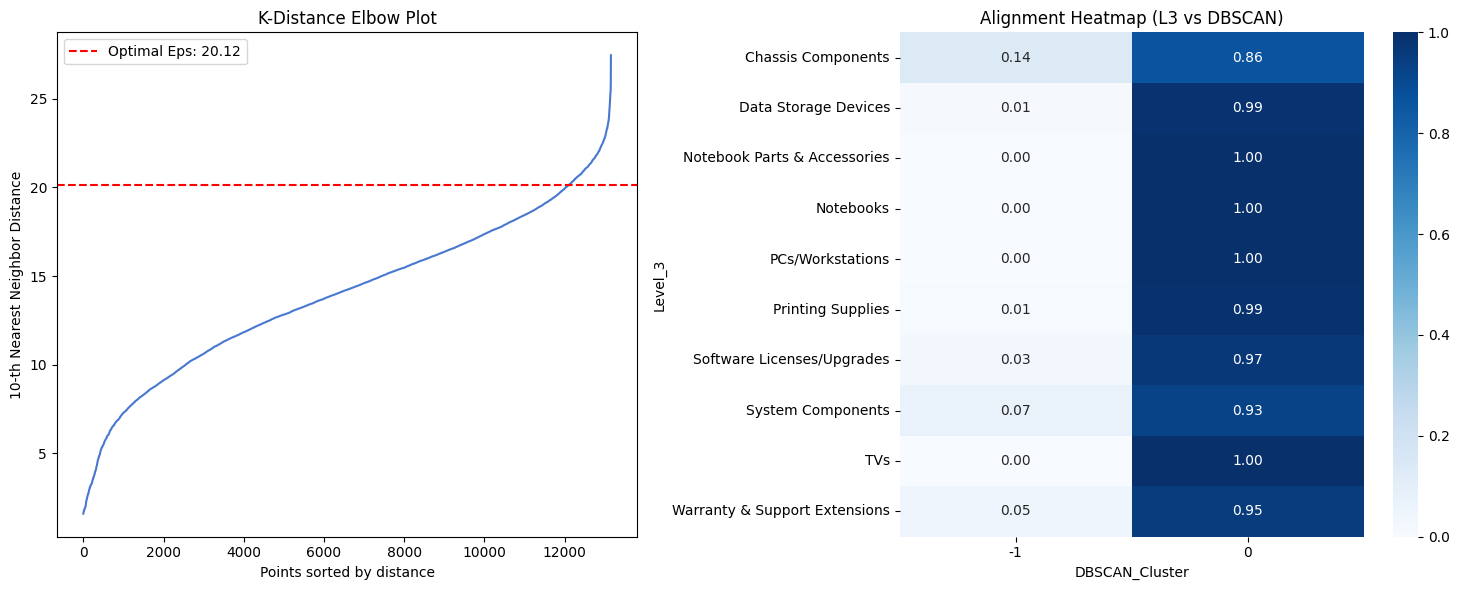

Total Clusters Found: 3

Audit: Items in Cluster 0:
['HP Pavilion 24-b100ur 60.5 cm (23.8") 1920 x 1080 pixels Intel® Pentium® G4400T 4 GB DDR4-SDRAM 1000 GB HDD White All-in-One PC', 'Lenovo V540 60.5 cm (23.8") 1920 x 1080 pixels Touchscreen 8th gen Intel® Core™ i3 i3-8145U 8 GB DDR4-SDRAM 1000 GB HDD Black All-in-One PC', 'ASUS Zen AiO Pro Z240ICGK-GC069X All-in-One PC/workstation 60.5 cm (23.8") 1920 x 1080 pixels 6th gen Intel® Core™ i5 i5-6400T 8 GB DDR4-SDRAM 1000 GB HDD Gold', 'MSI Pro 24 4BW-011EU 59.9 cm (23.6") 1920 x 1080 pixels Intel® Pentium® N3710 4 GB DDR3L-SDRAM 1000 GB HDD Black All-in-One PC', 'HP 20 -c471nd 49.5 cm (19.5") 1920 x 1080 pixels Intel® Celeron® J4005 4 GB DDR4-SDRAM 1000 GB HDD White All-in-One PC']


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, v_measure_score
import torch

def safe_join_text(x):
    if isinstance(x, list):
        # Join list elements with space, ignore empty items
        return " ".join([str(i) for i in x if i])
    if pd.isna(x):
        return ""
    return str(x)

def execute_ml_and_alignment_pipeline(df):
    """
    Updated Pipeline: High-Dimensional DBSCAN with Elbow Optimization.
    PROFESSOR REVISIONS: Removed PCA, replaced K-Means, added V-Measure.
    """
    print("Robust Feature Fusion (Handling Lists & Strings)\n")

    # Apply safe_join to both columns to prevent TypeError
    clean_titles = df['Title'].apply(safe_join_text)
    clean_descs = df['Description'].apply(safe_join_text)

    # Concatenate safely
    df['ml_input_text'] = clean_titles + " [SEP] " + clean_descs
    product_texts = df['ml_input_text'].tolist()

    # Part B: GPU Embedding
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Generating 384D Embeddings on {device.upper()}\n")
    model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

    # Generate embeddings (Full 384 Dimensions)
    embeddings = model.encode(product_texts, show_progress_bar=True, batch_size=128)

    # Part C: Scaling (Point 5: PCA Removed, scaling raw vectors instead)
    scaler = StandardScaler()
    scaled_vectors = scaler.fit_transform(embeddings)

    # Part D: POINT 4 - DBSCAN with Elbow Method Optimization
    print("Running Elbow Method for DBSCAN Epsilon Optimization...\n")
    k = 10 # min_samples heuristic
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(scaled_vectors)
    distances, indices = neighbors_fit.kneighbors(scaled_vectors)

    # Sort distances to find the elbow
    sorted_distances = np.sort(distances[:, k-1])

    # Mathematical Elbow Detection (Max perpendicular distance from chord)
    p1 = np.array([0, sorted_distances[0]])
    p2 = np.array([len(sorted_distances)-1, sorted_distances[-1]])
    all_points = np.vstack([np.arange(len(sorted_distances)), sorted_distances]).T
    dist_to_line = np.abs(np.cross(p2-p1, p1-all_points)) / np.linalg.norm(p2-p1)
    optimal_eps = sorted_distances[np.argmax(dist_to_line)]

    print(f"Mathematically Optimized Epsilon: {optimal_eps:.4f}\n")

    # Running DBSCAN with optimized epsilon
    dbscan = DBSCAN(eps=optimal_eps, min_samples=k)
    df['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_vectors)

    # Part E: Alignment Metrics (Point 6: Truth Check)
    print("\n5. Final Evaluation Metrics (Alignment with Level_3)\n")
    valid_mask = df['Level_3'].notna()

    # V-Measure is the harmonic mean of homogeneity and completeness
    v_score = v_measure_score(df.loc[valid_mask, 'Level_3'], df.loc[valid_mask, 'DBSCAN_Cluster'])
    ari = adjusted_rand_score(df.loc[valid_mask, 'Level_3'], df.loc[valid_mask, 'DBSCAN_Cluster'])

    print(f"V-Measure Score: {v_score:.4f}")
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")

    # Part F: Visualization
    plt.figure(figsize=(15, 6))

    # Subplot 1: K-Distance Elbow Plot
    plt.subplot(1, 2, 1)
    plt.plot(sorted_distances)
    plt.axhline(y=optimal_eps, color='r', linestyle='--', label=f'Optimal Eps: {optimal_eps:.2f}')
    plt.title("K-Distance Elbow Plot")
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"{k}-th Nearest Neighbor Distance")
    plt.legend()

    # Subplot 2: Alignment Heatmap (L3 vs Clusters)
    plt.subplot(1, 2, 2)
    # Focus on top categories/clusters for readability
    top_cats = df['Level_3'].value_counts().nlargest(10).index
    top_clasts = df['DBSCAN_Cluster'].value_counts().nlargest(10).index
    subset = df[df['Level_3'].isin(top_cats) & df['DBSCAN_Cluster'].isin(top_clasts)]

    if not subset.empty:
        ct = pd.crosstab(subset['Level_3'], subset['DBSCAN_Cluster'], normalize='index')
        sns.heatmap(ct, annot=True, cmap="Blues", fmt=".2f")
        plt.title("Alignment Heatmap (L3 vs DBSCAN)")
    else:
        print("Heatmap subset empty: Noise may be high or clusters too small.")

    plt.tight_layout()
    plt.show()

    # POINT 6: Audit Check
    n_clusters = len(set(df['DBSCAN_Cluster'])) - (1 if -1 in df['DBSCAN_Cluster'] else 0)
    print(f"Total Clusters Found: {n_clusters}")
    if n_clusters > 0:
        sample_cid = df[df['DBSCAN_Cluster'] != -1]['DBSCAN_Cluster'].value_counts().index[0]
        print(f"\nAudit: Items in Cluster {sample_cid}:")
        print(df[df['DBSCAN_Cluster'] == sample_cid]['Title'].head(5).tolist())

    return df

final_results_df = execute_ml_and_alignment_pipeline(analyzed_df)